In [1]:
# Standard library imports
import os
import sys

# Contributed library imports
import numpy as np
from pathlib import Path
import geopandas as gpd

# Our imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)
from IPython.core.debugger import set_trace

sys.path.append("../..")
from constants import (
    get_mesh_filename,
    get_camera_filename,
    get_predicted_vector_labels_filename,
    get_numpy_export_faces_texture_filename,
    get_oblique_images_folder,
    get_DTM_filename,
    get_prediction_folder,
    get_image_folder,
    get_IDs_to_labels,
    LABELS_FILENAME,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
TRAINING_SITES = sorted(["chips", "delta"])
PREDICTION_SITE_NAME = "lassic"

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 1 

# Aggregate predictions

In [4]:
MESH_FILENAME = get_mesh_filename(PREDICTION_SITE_NAME)
CAMERAS_FILENAME = get_camera_filename(PREDICTION_SITE_NAME)
IDs_TO_LABELS = get_IDs_to_labels()
print(CAMERAS_FILENAME)
print(MESH_FILENAME)
print(LABELS_FILENAME)
print(BUFFER_RADIUS_METERS)

label = gpd.read_file(LABELS_FILENAME)
label = label.query("fire=='lassic'")

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename="/ofo-share/str-disp_drone-data-partial/imagery-processed/outputs/120m-01/Lassic-120m_20240213T0503_cameras.xml",
    ROI=label,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
    IDs_to_labels=IDs_TO_LABELS,
)
print("Done creating mesh")

/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/02_photogrammetry/exports/cameras/Lassic-120m_20240213T0503_w-mesh_w-80m_20240214_aligned.xml
/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/02_photogrammetry/exports/meshes/Lassic-120m_20240213T0503_model_local.ply
/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/field_ref/crowns_drone_w_field_data_updated.gpkg
50
--Return--
None
> /tmp/ipykernel_3769/3532416052.py(11)<module>()
      9 label = gpd.read_file(LABELS_FILENAME)
     10 label = label.query("fire=='lassic'")
---> 11 set_trace()
     12 
     13 mesh = TexturedPhotogrammetryMesh(



ipdb>  c


Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Done creating mesh


/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/02_photogrammetry/exports/cameras/Lassic-120m_20240213T0503_w-mesh_w-80m_20240214_aligned.xml


Loading GPS data for camera set: 100%|██████████| 19175/19175 [00:00<00:00, 2196825.44it/s]


About to vis
This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


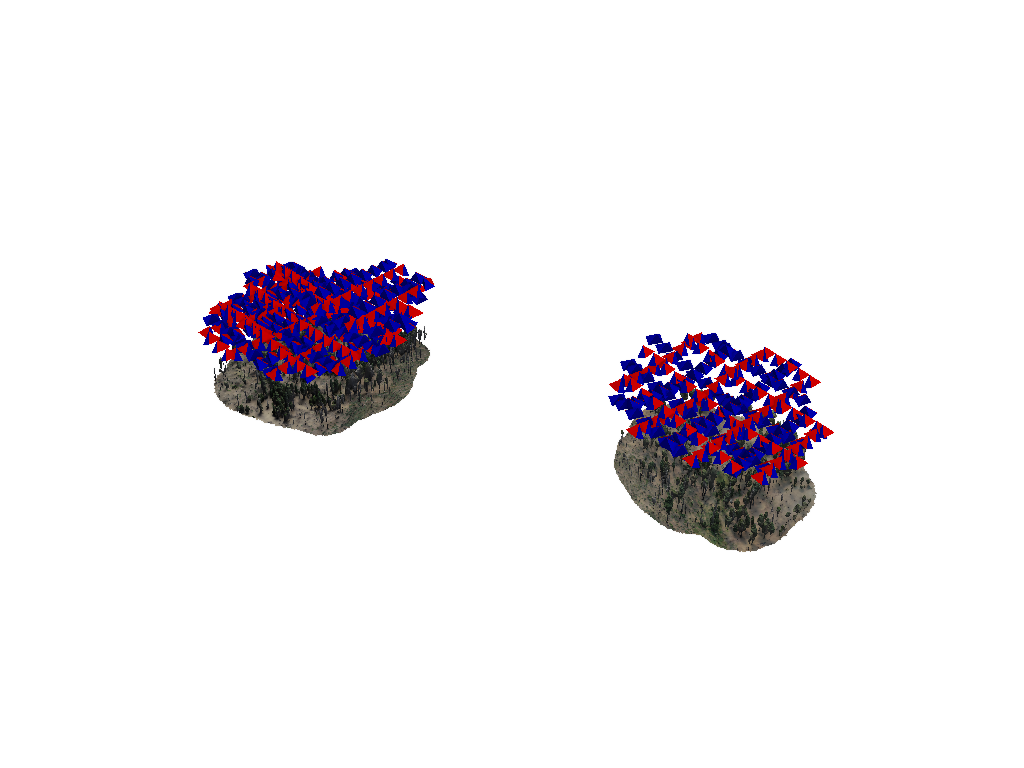

In [5]:
IMAGE_FOLDER = get_image_folder(PREDICTION_SITE_NAME)
OBLIQUE_IMAGES_FOLDER = get_oblique_images_folder(PREDICTION_SITE_NAME)

# Create camera set
print(CAMERAS_FILENAME)
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set = training_camera_set.get_cameras_in_folder(OBLIQUE_IMAGES_FOLDER)
print("About to vis")
# %%
mesh.vis(camera_set=training_camera_set, force_xvfb=True)

In [6]:
PREDICTIONS_FOLDER = get_prediction_folder(
    prediction_site=PREDICTION_SITE_NAME, training_sites=TRAINING_SITES, is_ortho=False
)
# %%
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTIONS_FOLDER,
    num_classes=8,
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

aggregated_face_labels, _, _ = mesh.aggregate_viewpoints_pytorch3d(
    segmentor_camera_set,
    image_scale=AGGREGATE_IMAGE_SCALE,
)

Aggregating information from different viewpoints: 100%|██████████| 496/496 [1:01:48<00:00,  7.48s/it]
/ofo-share/repos-david/multiview-mapping-toolkit-stable/multiview_mapping_toolkit/meshes/meshes.py:1266: RuntimeWarning: invalid value encountered in divide
  normalized_face_texture = face_texture / np.expand_dims(counts, 1)


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/02_photogrammetry/exports/dtms/lassic.tif: 100%|██████████| 466612/466612 [00:17<00:00, 26346.51it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


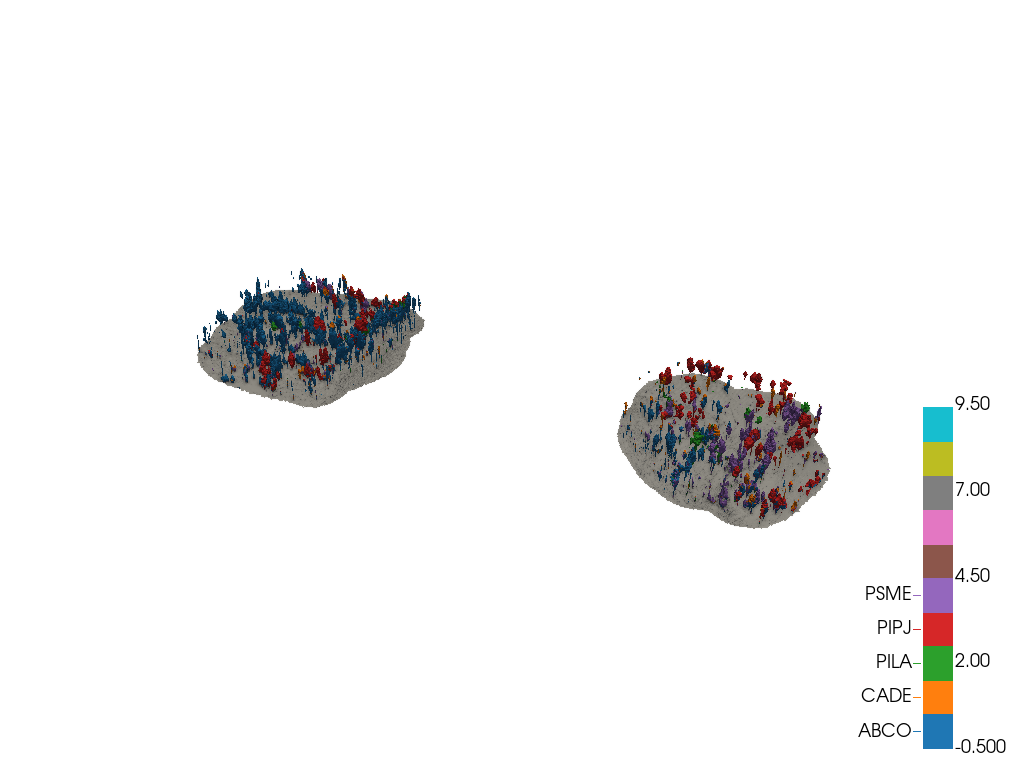

Computing working CRS
Computing faces in working CRS


Converting faces to polygons: 100%|██████████| 927626/927626 [00:14<00:00, 65094.88it/s]

Creating dataframe of faces


Creating dataframe of multipolygons


Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:21<00:00, 21.15s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:09<00:00,  9.23s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Plotting


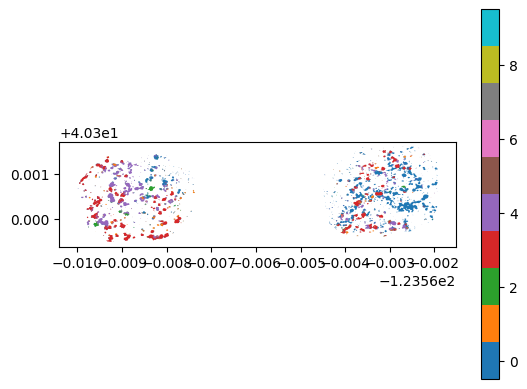

,class_ID,geometry
0,0.0,"MULTIPOLYGON (((-123.56960 40.29971, -123.5696..."
1,1.0,"MULTIPOLYGON (((-123.56942 40.29962, -123.5694..."
2,2.0,"MULTIPOLYGON (((-123.56942 40.29961, -123.5694..."
3,3.0,"MULTIPOLYGON (((-123.56941 40.29963, -123.5694..."
4,4.0,"MULTIPOLYGON (((-123.56975 40.29981, -123.5697..."


In [9]:
from pathlib import Path
NUMPY_EXPORT_FACES_TEXTURE_FILE = Path("/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/05_processed_predictions/lassic_80m_chips_model.npy")
DTM_FILE = get_DTM_filename(PREDICTION_SITE_NAME)
#NUMPY_EXPORT_FACES_TEXTURE_FILE = get_numpy_export_faces_texture_filename(PREDICTION_SITE_NAME)
PREDICTED_VECTOR_LABELS_FILE = get_predicted_vector_labels_filename(PREDICTION_SITE_NAME)
# %%
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)
NUMPY_EXPORT_FACES_TEXTURE_FILE.parent.mkdir(parents=True, exist_ok=True)
np.save(NUMPY_EXPORT_FACES_TEXTURE_FILE, predicted_face_classes)
# %%
mesh.vis(
    vis_scalars=predicted_face_classes,
    force_xvfb=True,
)

mesh.export_face_labels_vector(
    face_labels=np.squeeze(predicted_face_classes),
    export_file=PREDICTED_VECTOR_LABELS_FILE,
    vis=True,
    vis_kwargs={"cmap": "tab10", "vmin": -0.5, "vmax": 9.5},
)

In [10]:
np.save("/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/05_processed_predictions/lassic_80m_chips_model_aggregated.npy", aggregated_face_labels)